In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import *
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np



In [2]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.WordNetLemmatizer()

In [3]:
df_consp = pd.read_csv(f'./data/conspiracy_submissions_redditapi.csv')
df_consp['label'] = 0

In [4]:
df_science = pd.read_csv(f'./data/worldnews_submissions_redditapi.csv')
df_science['label'] = 1
df_science
df = pd.concat([df_consp, df_science], axis=0)


In [5]:
submissions = df.title.values

In [6]:
def preprocessing(text):
    text = str(text)
    text = text.lower()
    return re.sub(r"(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|^&gt;","",text)

def tokenize(text):
    text = re.sub(r"[^0-9A-Za-z' \t]","",text)
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word, pos="v") for word in text]
    return text



In [7]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing,
            tokenizer=tokenize,
            stop_words=nltk.corpus.stopwords.words('english'),
            ngram_range=(1,2),
            min_df=5)
tfidf = tfidf_vectorizer.fit_transform(submissions).toarray()


C:\Users\isoma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  warnings.warn(


In [8]:
SentimentAnalyzer = SentimentIntensityAnalyzer()
sentiments = []
for comment in submissions:
    sentiment = SentimentAnalyzer.polarity_scores(comment)
    sentiments.append([sentiment['pos'], sentiment['neg'], sentiment['neu']])



In [9]:
reddit_features = df[['num_comments', 'score']].to_numpy()
reddit_features

array([[   9,    4],
       [  49,  172],
       [  20,    8],
       ...,
       [  10,    0],
       [ 113, 1272],
       [   0,    1]], dtype=int64)

In [10]:
features = np.concatenate([tfidf, reddit_features, sentiments], axis=1)
features.shape

(21508, 8242)

In [11]:
X = pd.DataFrame(features)
y = df['label'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
#class_weight penalty='l2' multi_class='ovr', , C=0.01

y_predict = model.predict(X_test)

rep = classification_report(y_test, y_predict)

print(rep)


              precision    recall  f1-score   support

           0       0.85      0.71      0.77      1408
           1       0.87      0.94      0.90      2894

    accuracy                           0.86      4302
   macro avg       0.86      0.82      0.84      4302
weighted avg       0.86      0.86      0.86      4302



C:\Users\isoma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


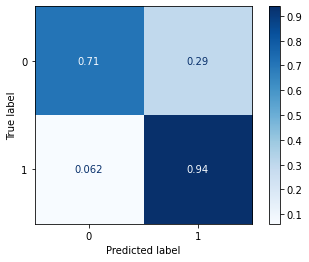

In [14]:
conf_matrix = confusion_matrix(y_test, y_predict, normalize='true')
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot(cmap='Blues')

results 93 83 mit pushshift